<a href="https://colab.research.google.com/github/torifinch/TimeSeriesAnalysis/blob/main/GroceryStore_TimeSeries_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparing Data

In [329]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [330]:
# Unzip the downloaded dataset
!unzip /content/drive/MyDrive/retail_kaggle_data/favorita-grocery-sales-forecasting.zip

Archive:  /content/drive/MyDrive/retail_kaggle_data/favorita-grocery-sales-forecasting.zip
replace holidays_events.csv.7z? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [331]:
!apt-get install -y p7zip-full

^C


In [ ]:
# Extract the files
!7z e train.csv.7z
!7z e stores.csv.7z
!7z e items.csv.7z
!7z e holidays_events.csv.7z
!7z e oil.csv.7z
!7z e transactions.csv.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs AMD EPYC 7B12 (830F10),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 474092593 bytes (453 MiB)

Extracting archive: train.csv.7z
--
Path = train.csv.7z
Type = 7z
Physical Size = 474092593
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%    
Would you like to replace the existing file:
  Path:     ./train.csv
  Size:     4997452288 bytes (4766 MiB)
  Modified: 2017-10-19 15:30:05
with the file from archive:
  Path:     train.csv
  Size:     4997452288 bytes (4766 MiB)
  Modified: 2017-10-19 15:30:05
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? 
7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs AMD EPYC 7B12 (830F10),ASM,AES-NI)

Scanning the drive for archives:

#EDA for Time-series data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('stores.csv')
df_items = pd.read_csv('items.csv')
df_transactions = pd.read_csv('transactions.csv')
df_oil = pd.read_csv('oil.csv')
df_holidays_events = pd.read_csv('holidays_events.csv')

# Note: train file is very large.
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv('train.csv', nrows=2e6)

In [3]:
df_train.shape

(2000000, 6)

## Filtering by Region
Selecting only data for “Guayas” region to further filter our data

In [4]:
# Select list of stores located in the 'Guayas' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-4-b3ad23cc94c1>:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('train.csv', chunksize=chunk_size):


In [5]:
# Filter for only January-March 2014, including March
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train[(df_train['date'] >= '2014-01-01') & (df_train['date'] <= '2014-3-31')]


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 996117 entries, 2984224 to 3980340
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           996117 non-null  int64         
 1   date         996117 non-null  datetime64[ns]
 2   store_nbr    996117 non-null  int64         
 3   item_nbr     996117 non-null  int64         
 4   unit_sales   996117 non-null  float64       
 5   onpromotion  0 non-null       object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 53.2+ MB


##Top 3 Families
Selecting only the Top 3 families by the total number of items

In [7]:
# Get the top-3 families by the number of items
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)  # here is where we get the top-3 families

item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]


In [8]:
top_3_families.head()

,Family,Item Count
0,GROCERY I,1334
1,BEVERAGES,613
2,CLEANING,446


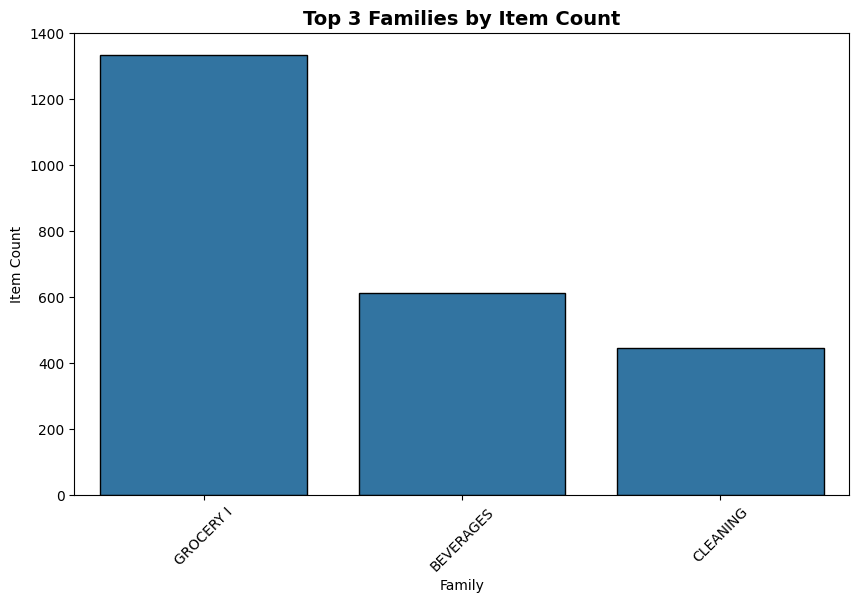

In [9]:
# Plot item count for top 3 families
plt.figure(figsize=(10, 6))
sns.barplot(x='Family', y='Item Count', data=top_3_families, edgecolor='black')
plt.title('Top 3 Families by Item Count', fontsize=14, fontweight='bold')
plt.xlabel('Family')
plt.ylabel('Item Count')
plt.xticks(rotation=45)
plt.show()

In [10]:
# Loads first 5 rows
df_train.head(5)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
2984224,16323658,2014-01-01,36,96995,1.0,NaN
2984226,16323660,2014-01-01,36,105576,4.0,NaN
2984227,16323661,2014-01-01,36,105693,1.0,NaN
2984228,16323662,2014-01-01,36,106716,3.0,NaN
2984231,16323665,2014-01-01,36,108786,1.0,NaN


In [11]:
df_train.shape

(629145, 6)

##Checking for Missing Data

In [12]:
df_stores.isnull().sum()

,0
store_nbr,0
city,0
state,0
type,0
cluster,0


In [13]:
df_holidays_events.isnull().sum()

,0
date,0
type,0
locale,0
locale_name,0
description,0
transferred,0


In [14]:
df_items.isnull().sum()

,0
item_nbr,0
family,0
class,0
perishable,0


###Oil Price Nulls

Since filling missing oil prices with 0 would distort the data, I will instead forward-fill them using the price from the previous day.

In [15]:
# Check for nulls in df_oil
df_oil.isnull().sum()

,0
date,0
dcoilwtico,43


In [16]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [17]:
# Fill null values in dcoilwtico using ffill (uses previous value to fill)
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill')
# Use bfill to fill the first missing value with the one after it
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='bfill')

<ipython-input-17-a949b0c92851>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill')
<ipython-input-17-a949b0c92851>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='bfill')


In [18]:
df_oil.isnull().sum()

,0
date,0
dcoilwtico,0


###On Promotion Nulls

Since only nulls are found in the onpromotion column, I will replace them with 0. This approach treats missing promotion data as 'not on promotion,' making the analysis cleaner and more consistent.

In [19]:
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,629145


In [20]:
df_train['onpromotion'].value_counts()

,count
onpromotion,


In [21]:
# Replacing on missing values in the 'onpromotion' column
df_train['onpromotion'] = df_train['onpromotion'].fillna(0).astype(int)

<ipython-input-21-eba66aea4bd7>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(0).astype(int)


## Negative sales
Replacing negative sales with 0 to reflect returns as non-sales

In [22]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

negative_sales.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
3073335,16812790,2014-01-09,27,1464034,-2.000,0
3079181,16820878,2014-01-09,36,1124165,-3.000,0
3079822,16841624,2014-01-09,51,374464,-11.000,0
3093317,16936170,2014-01-11,24,885553,-3.000,0
3099934,16945517,2014-01-11,32,1391408,-0.495,0


##Handling Outliers

Calculate Z-score, checking against > 5, which is a very high threshold.

In [23]:
# Calculate store-item combination Z-score
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score (avoiding division by zero for standard deviation)
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

# Apply the Z-score calculation to each store-item group without resetting the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

# Define threshold for outliers (Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 752


<ipython-input-23-24478d938c4b>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
60,18886543,2014-02-13,24,103520,22.0,0,5.200925
183,21294315,2014-03-26,24,105574,40.0,0,5.544436
3037,18487433,2014-02-05,24,129758,31.0,0,5.516425
4803,16352845,2014-01-02,24,165988,51.0,0,5.783188
5093,18934767,2014-02-14,24,168989,77.0,0,5.530056


Plot which dates were the highest for the top item sold in the outliers

In [24]:
# Dates with highest sales
outliers['date'].head()

,date
60,2014-02-13
183,2014-03-26
3037,2014-02-05
4803,2014-01-02
5093,2014-02-14


In [25]:
# Count outliers per item
top_outlier_items = outliers['item_nbr'].value_counts().head(10)
print(top_outlier_items)


item_nbr
417835     7
1158720    7
268662     6
168989     6
1060036    5
311954     5
1003679    5
956012     4
1159726    4
1105212    4
Name: count, dtype: int64


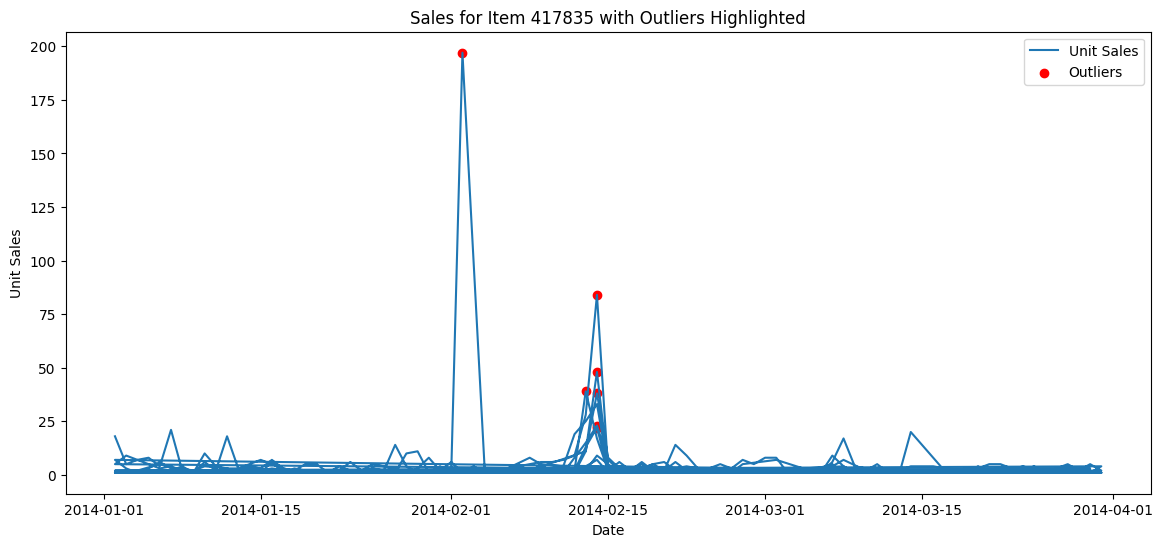

In [26]:
import matplotlib.pyplot as plt

# Choose one item to plot
top_outlier = top_outlier_items.index[0]

item_sales = df_train_grouped[df_train_grouped['item_nbr'] == top_outlier]

plt.figure(figsize=(14, 6))
plt.plot(item_sales['date'], item_sales['unit_sales'], label='Unit Sales')
plt.scatter(item_sales[item_sales['z_score'] > 5]['date'],
            item_sales[item_sales['z_score'] > 5]['unit_sales'],
            color='red', label='Outliers')

plt.title(f"Sales for Item {top_outlier} with Outliers Highlighted")
plt.xlabel("Date")
plt.ylabel("Unit Sales")
plt.legend()
plt.show()

In [27]:
#Check unit sales over 175 per order for item 417835
outliers[(outliers['unit_sales'] > 175) & (outliers['item_nbr'] == 417835)]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
22222,18334035,2014-02-02,24,417835,197.0,0,8.141835


In [28]:
#Fiter to see date 2014-02-13
outliers[outliers['date'] == '2014-02-13']

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
60,18886543,2014-02-13,24,103520,22.0,0,5.200925
57241,18887499,2014-02-13,24,1086172,13.0,0,5.924587
64063,18887603,2014-02-13,24,1159726,38.0,0,6.397811
187850,18890300,2014-02-13,27,1159726,13.0,0,5.249136
204013,18890493,2014-02-13,28,168989,26.0,0,5.011159
246301,18891152,2014-02-13,28,1047395,60.0,0,7.698923
253187,18891248,2014-02-13,28,1105228,61.0,0,5.197625
370206,18894599,2014-02-13,34,168989,51.0,0,7.048663
572172,18913035,2014-02-13,51,417835,39.0,0,6.645596
616132,18913778,2014-02-13,51,1159726,25.0,0,6.770609


In [29]:
# Only show holidays in 2014
year = 2014
df_holidays_events['year'] = pd.to_datetime(df_holidays_events['date']).dt.year
holidays_2014 = df_holidays_events[df_holidays_events['year'] == year]
holidays_2014.head()


,date,type,locale,locale_name,description,transferred,year
92,2014-01-01,Holiday,National,Ecuador,Primer dia del ano,False,2014
93,2014-03-02,Holiday,Local,Manta,Fundacion de Manta,False,2014
94,2014-03-03,Holiday,National,Ecuador,Carnaval,False,2014
95,2014-03-04,Holiday,National,Ecuador,Carnaval,False,2014
96,2014-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,2014


###Valentine's Sales
The top date for unit sales for the top outlier product is Feb 13, 2014 this could be attributed to high sales for Valentines Day, though it's not listed as an offical holiday.

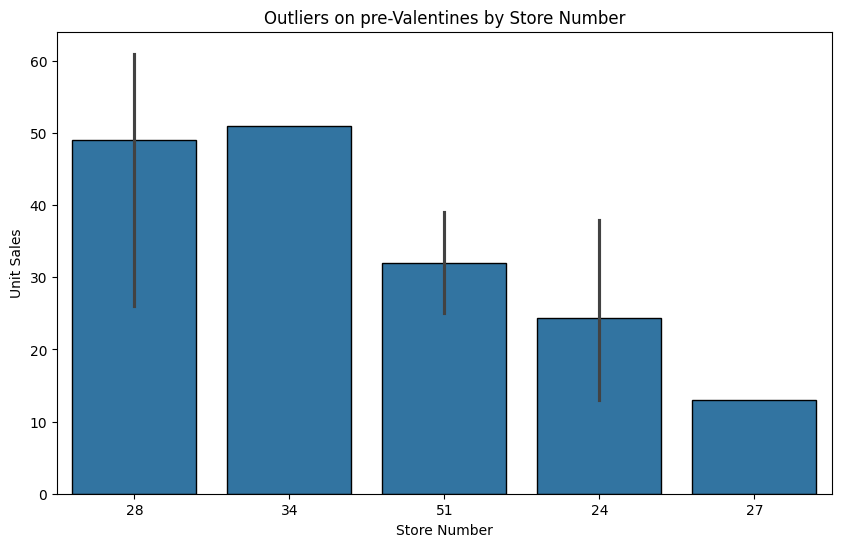

In [30]:
# Investigate outliers on 2014-02-13 by store_nbr
outliers[outliers['date'] == '2014-02-13'].sort_values('unit_sales', ascending=False)
plt.figure(figsize=(10, 6))
# Order by unit sales
sns.barplot(x='store_nbr', y='unit_sales', data=outliers[outliers['date'] == '2014-02-13'], edgecolor='black', order=outliers[outliers['date'] == '2014-02-13'].sort_values('unit_sales', ascending=False)['store_nbr'])
plt.title('Outliers on pre-Valentines by Store Number')
plt.xlabel('Store Number')
plt.ylabel('Unit Sales')
plt.show()

###Remove Outliers

In [31]:
# Remove outliers
df_train = df_train[~df_train['id'].isin(outliers['id'])]

##Fill missing dates with zero sales

In [32]:
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Get full date range
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})

# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how='cross')

# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)

# Check the first few rows
df_filled.head()

<ipython-input-32-bd4057d47105>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['date'] = pd.to_datetime(df_train['date'])


,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,36,96995,2014-01-01,16323658.0,1.0,0.0
1,36,96995,2014-01-02,16365887.0,7.0,0.0
2,36,96995,2014-01-03,NaN,0.0,NaN
3,36,96995,2014-01-04,16499179.0,2.0,0.0
4,36,96995,2014-01-05,16567119.0,1.0,0.0


In [33]:
# Fill null values in dcoilwtico using ffill (uses previous value to fill)
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill')
# Use bfill to fill the first missing value with the one after it
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='bfill')

<ipython-input-33-a949b0c92851>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill')
<ipython-input-33-a949b0c92851>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='bfill')


## Feature Engineering

###Creating Time-based features
I am creating time-based features like is it a weekend, is it a holiday, and whether it is the day before a holiday hich can also contribute to sales fluctuations.

In [34]:
# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['week_of_year'] = df_train['date'].dt.isocalendar().week
df_train['is_weekend'] = (df_train['day_of_week'] >= 5).astype(int)
df_train['is_holiday'] = df_train['date'].isin(holidays_2014['date']).astype(int)
df_train['day_before_holiday'] = (df_train['date'] - pd.to_timedelta(1, unit='D')).isin(holidays_2014['date']).astype(int)

<ipython-input-34-f07d32858593>:11: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_train['is_holiday'] = df_train['date'].isin(holidays_2014['date']).astype(int)
<ipython-input-34-f07d32858593>:12: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_train['day_before_holiday'] = (df_train['date'] - pd.to_timedelta(1, unit='D')).isin(holidays_2014['date']).astype(int)


###Expanding Window Features

In [35]:
# Expanding Mean
df_train['expanding_mean'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.expanding().mean())


###Adding Columns
Joining oil prices to df_train

In [36]:
# Convert 'date' column in df_oil to datetime before merging
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Join df_oil to df_train
df_train = pd.merge(df_train, df_oil, on='date', how='left')


In [37]:
# Rename dcoilwtico to oil_price
df_train.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)

In [38]:
# Fill null values in dcoilwtico using ffill (uses previous value to fill)
df_train['oil_price'] = df_train['oil_price'].fillna(method='ffill')

<ipython-input-38-d633111b2740>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train['oil_price'] = df_train['oil_price'].fillna(method='ffill')


In [39]:
# Check nulls
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0
year,0
month,0
day,0
day_of_week,0


##Smoothing
Using 7 mean smoothed because the data is by day and we want a week at a time.

In [44]:
df_train['rolling_mean_7d'] = df_train['unit_sales'].rolling(window=7).mean()
df_train['rolling_mean_14d'] = df_train['unit_sales'].rolling(window=14).mean()

df_train['rolling_std_7d'] = df_train['unit_sales'].rolling(window=7).std()
df_train['rolling_std_14d'] = df_train['unit_sales'].rolling(window=14).std()

### Lag features

In [41]:
# Create lag features (e.g., sales from the previous day, previous week)
df_train['lag_1'] = df_train['unit_sales'].shift(1)
df_train['lag_7'] = df_train['unit_sales'].shift(7)
df_train['lag_14'] = df_train['unit_sales'].shift(14)

# Drop any rows with NaN values after creating lag features
df_train.dropna(inplace=True)

In [42]:
df_train.tail()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,day_before_holiday,expanding_mean,oil_price,rolling_mean_7,rolling_mean_14,rolling_std_7,rolling_std_14,lag_1,lag_7,lag_14
628388,21656539,2014-03-31,51,1464239,4.0,0,2014,3,31,0,...,0,8.594595,101.57,9.142857,9.642857,8.532850,7.479275,7.0,2.0,1.0
628389,21656540,2014-03-31,51,1464246,3.0,0,2014,3,31,0,...,0,4.450000,101.57,8.428571,8.357143,8.847921,6.901584,4.0,8.0,21.0
628390,21656541,2014-03-31,51,1464941,18.0,0,2014,3,31,0,...,0,23.283333,101.57,10.142857,9.071429,9.441550,7.363781,3.0,6.0,8.0
628391,21656542,2014-03-31,51,1466047,5.0,0,2014,3,31,0,...,0,3.925000,101.57,10.428571,8.714286,9.216962,7.436175,18.0,3.0,10.0
628392,21656543,2014-03-31,51,1466049,3.0,0,2014,3,31,0,...,0,3.487805,101.57,6.857143,7.642857,5.273474,7.066793,5.0,28.0,18.0


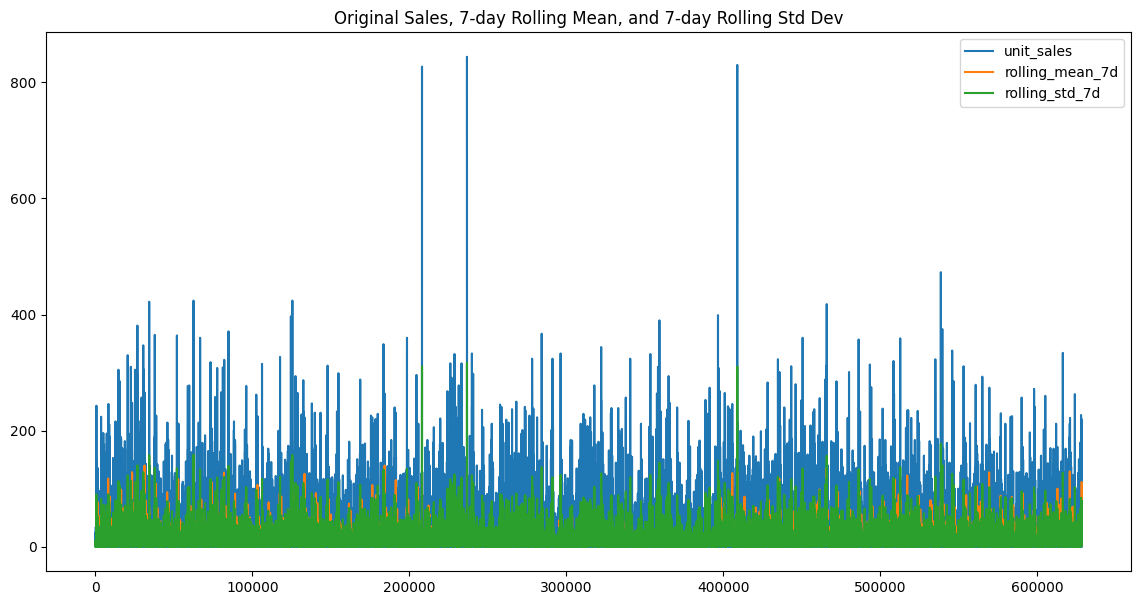

In [45]:
# Visualize the new features alongside the original sales
df_train[['unit_sales', 'rolling_mean_7d', 'rolling_std_7d']].plot(figsize=(14, 7))
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.show()

##Visualizing Time-Series Data

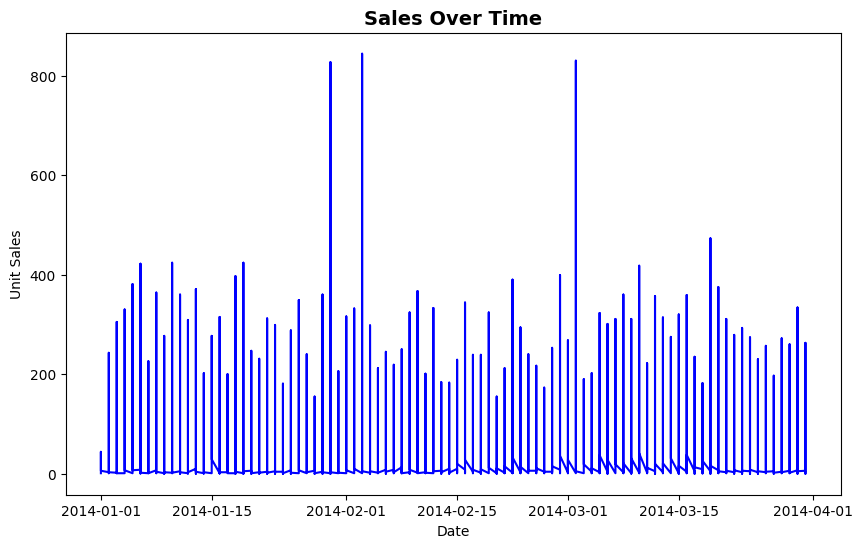

In [46]:
# Visualize the Sales Data over time
plt.figure(figsize=(10, 6))

plt.plot('date', 'unit_sales', data=df_train, color='blue')
plt.title('Sales Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.show()

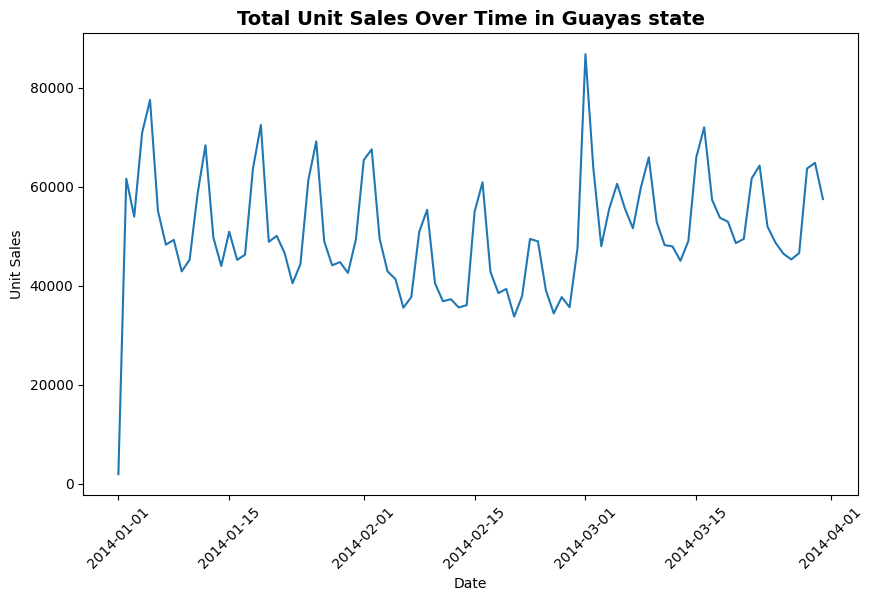

In [47]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(10,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.xticks(rotation=45)

plt.show()

In [48]:
# Aggregating sales by year and month and day
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

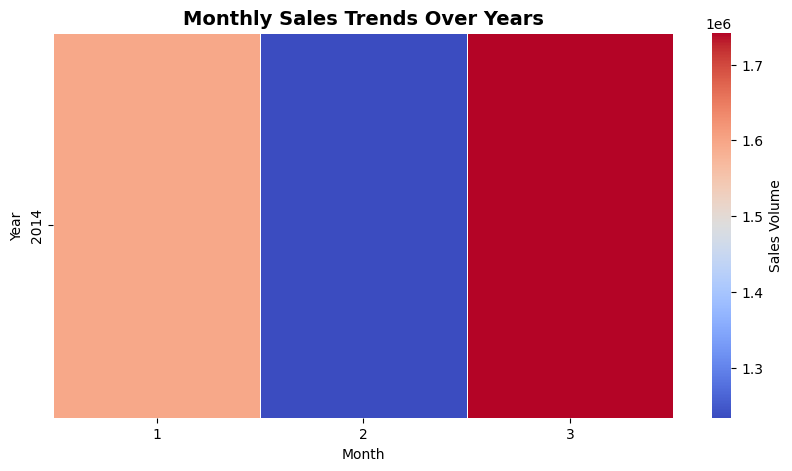

In [49]:
# Plotting heatmap of sales by year and month

plt.figure(figsize=(10, 5))
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Sales Volume'}
)

plt.title('Monthly Sales Trends Over Years', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Year')

plt.show()

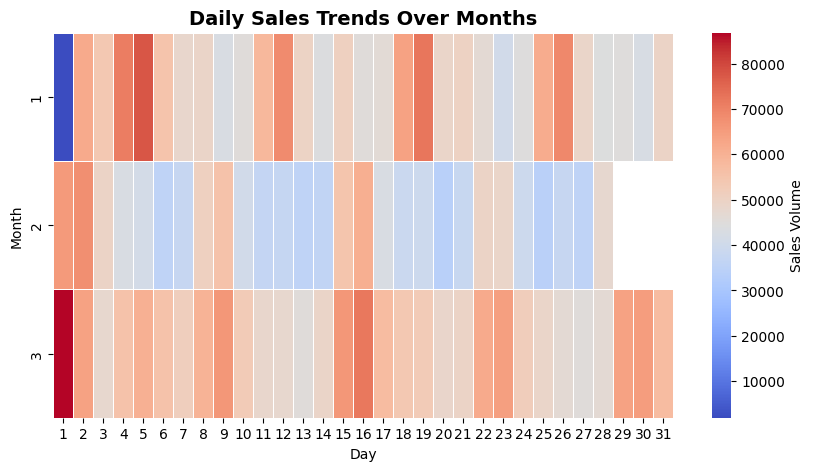

In [50]:
# Aggregating sales by year and month and day
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

# Reshape sales_by_day to be compatible with heatmap
sales_by_day = df_train.groupby(['year', 'month', 'day'])['unit_sales'].sum().reset_index()  # Create a DataFrame
sales_by_day = sales_by_day.pivot(index='month', columns='day', values='unit_sales')  # Pivot to create 2D structure

# Plotting heatmap of sales by month and day

plt.figure(figsize=(10, 5))
sns.heatmap(
    sales_by_day,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Sales Volume'}

)

plt.title('Daily Sales Trends Over Months', fontsize=14, fontweight='bold')
plt.xlabel('Day')
plt.ylabel('Month')
plt.show()

January 1, 2014 is New Year's Day, a public holiday during which most stores are closed. As a result, it is expected that sales would be significantly lower on this date.

Sales saw a significant spike on May 1, likely due to the upcoming national holiday in Ecuador — Carnaval.

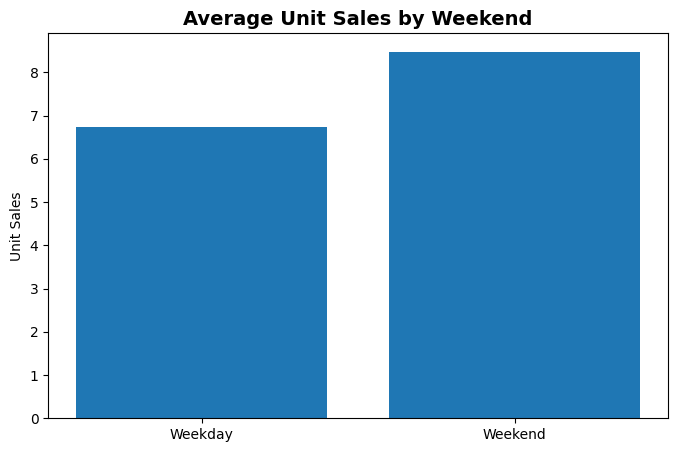

In [51]:
# Avg Sales by Weekend or Weekday using is_weekend
sales_by_weekend = df_train.groupby('is_weekend')['unit_sales'].mean()

# Plotting the sales by weekend
plt.figure(figsize=(8, 5))
plt.bar(sales_by_weekend.index, sales_by_weekend.values)
plt.title('Average Unit Sales by Weekend', fontsize=14, fontweight='bold')
plt.ylabel('Unit Sales')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()

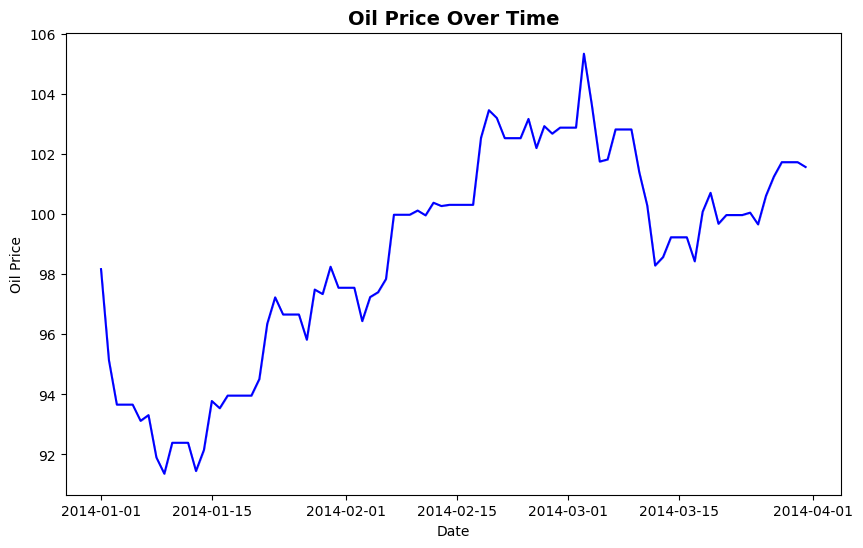

In [52]:
# Oil Price over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='oil_price', data=df_train, color='blue')
plt.title('Oil Price Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.show()

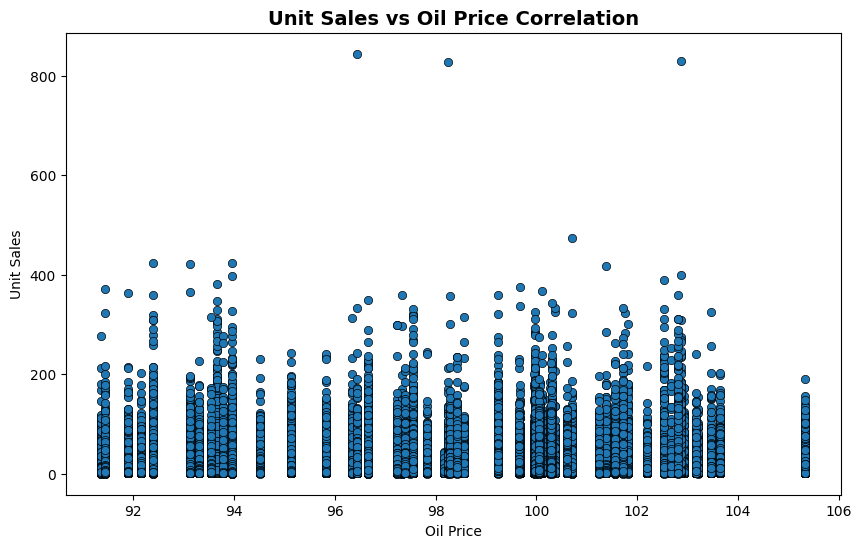

In [53]:
# Sales vs Oil Price correlation graph
plt.figure(figsize=(10, 6))
sns.scatterplot(x='oil_price', y='unit_sales', data=df_train, edgecolor='black')
plt.title('Unit Sales vs Oil Price Correlation', fontsize=14, fontweight='bold')
plt.xlabel('Oil Price')
plt.ylabel('Unit Sales')
plt.show()

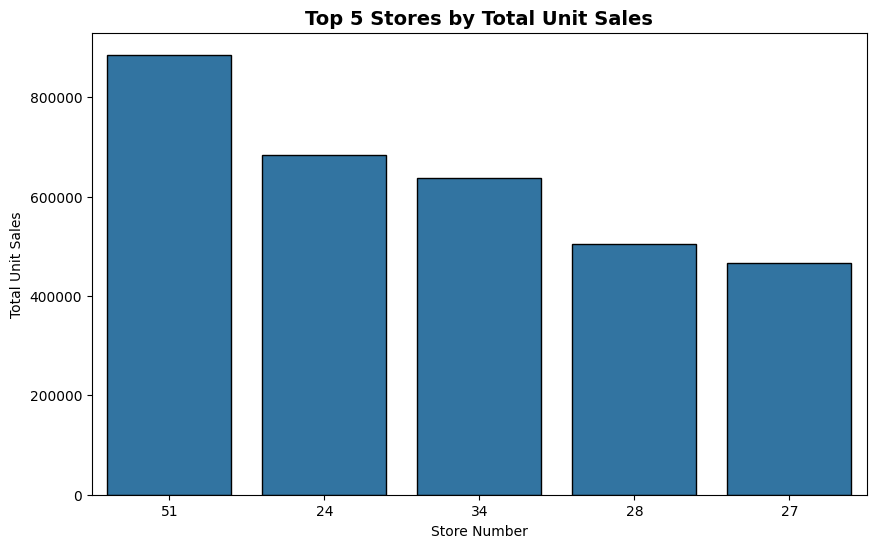

In [54]:
# Stores with highest sales
top_stores = df_train.groupby('store_nbr')['unit_sales'].sum().nlargest(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_stores.index, y=top_stores.values, edgecolor='black', order=top_stores.index)
plt.title('Top 5 Stores by Total Unit Sales', fontsize=14, fontweight='bold')
plt.xlabel('Store Number')
plt.ylabel('Total Unit Sales')
plt.show()

In [55]:
# Find Top Stores Locations
top_stores_locations = df_stores[df_stores['store_nbr'].isin(top_stores.index)]
top_stores_locations

,store_nbr,city,state,type,cluster
23,24,Guayaquil,Guayas,D,1
26,27,Daule,Guayas,D,1
27,28,Guayaquil,Guayas,E,10
33,34,Guayaquil,Guayas,B,6
50,51,Guayaquil,Guayas,A,17


###Guayaquil
Santiago de Guayaquil, is the largest city in Ecuador and also the nation's economic capital and main port.

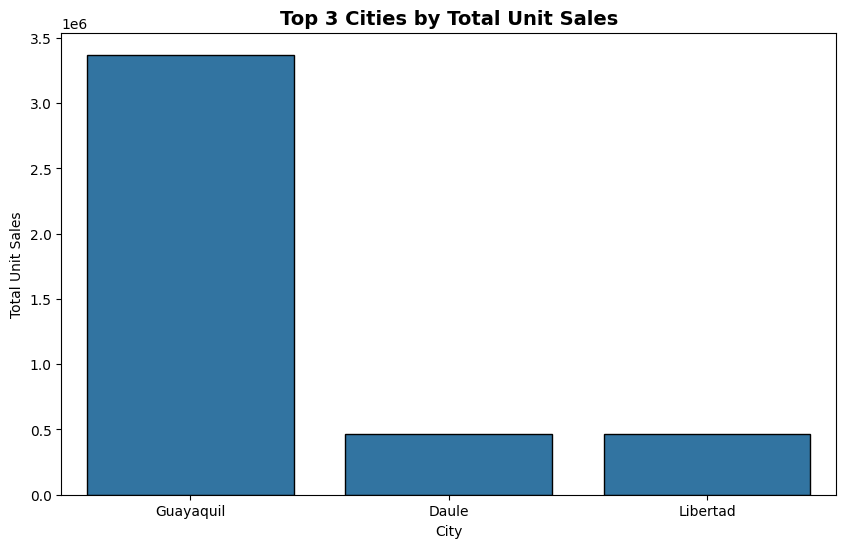

In [56]:
df_stores_train = pd.merge(df_train, df_stores, on='store_nbr', how='left')
#City with highest sales
top_city = df_stores_train.groupby('city')['unit_sales'].sum().nlargest(3)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_city.index, y=top_city.values, edgecolor='black', order=top_city.index)
plt.title('Top 3 Cities by Total Unit Sales', fontsize=14, fontweight='bold')
plt.xlabel('City')
plt.ylabel('Total Unit Sales')
plt.show()

##Examining the Impact of Holidays


In [57]:
# Join holidays and train df
df_train_holiday = pd.merge(df_train, df_holidays_events.astype({'date': 'datetime64[ns]'}), on='date', how='left')
# This ensures both date columns are datetime64[ns] type

In [58]:
# All holiday types
df_train_holiday['type'].value_counts()

,count
type,
Holiday,22893


In [59]:
# Count values is_weeked
df_train_holiday['is_holiday'].value_counts()

,count
is_holiday,
0,605486
1,22893


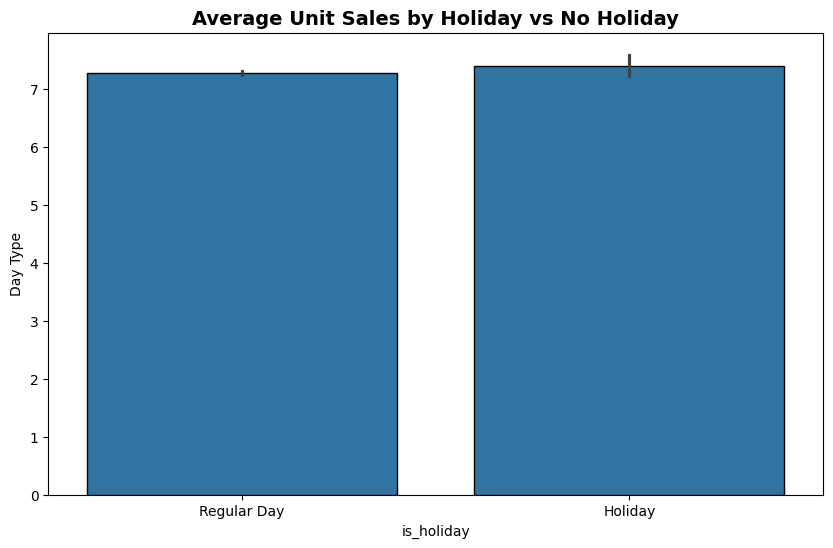

In [60]:
# Avg sales by holiday type
plt.figure(figsize=(10, 6))
sns.barplot(x='is_holiday', y='unit_sales', data=df_train_holiday, edgecolor='black')
plt.title('Average Unit Sales by Holiday vs No Holiday', fontsize=14, fontweight='bold')
plt.ylabel('Average Unit Sales')
plt.ylabel('Day Type')
plt.xticks([0, 1], ['Regular Day', 'Holiday']) #rename 0,1
plt.show()


###January 1
Analyzing if Low Sales on January 1 have an impact on Avg Sales of Holidays

In [61]:
# Remove 01-01-2014
df_train_holiday = df_train_holiday[df_train_holiday['date'] != '2014-01-01']

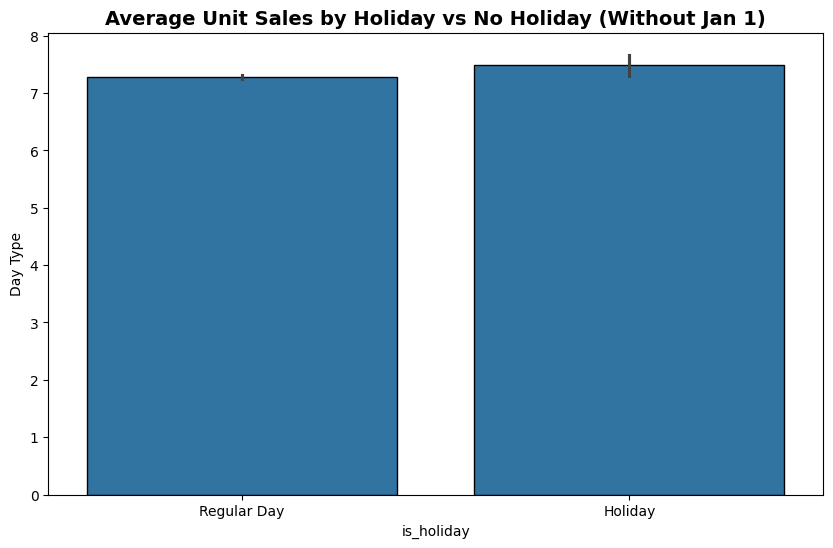

In [62]:
# Avg sales by holiday type, without Jan 1
plt.figure(figsize=(10, 6))
sns.barplot(x='is_holiday', y='unit_sales', data=df_train_holiday, edgecolor='black')
plt.title('Average Unit Sales by Holiday vs No Holiday (Without Jan 1)', fontsize=14, fontweight='bold')
plt.ylabel('Average Unit Sales')
plt.ylabel('Day Type')
plt.xticks([0, 1], ['Regular Day', 'Holiday']) #rename 0,1
plt.show()


Despite low sales, January 1st has no significant affect on the sales average of holiday days.

### Correlation Matrix

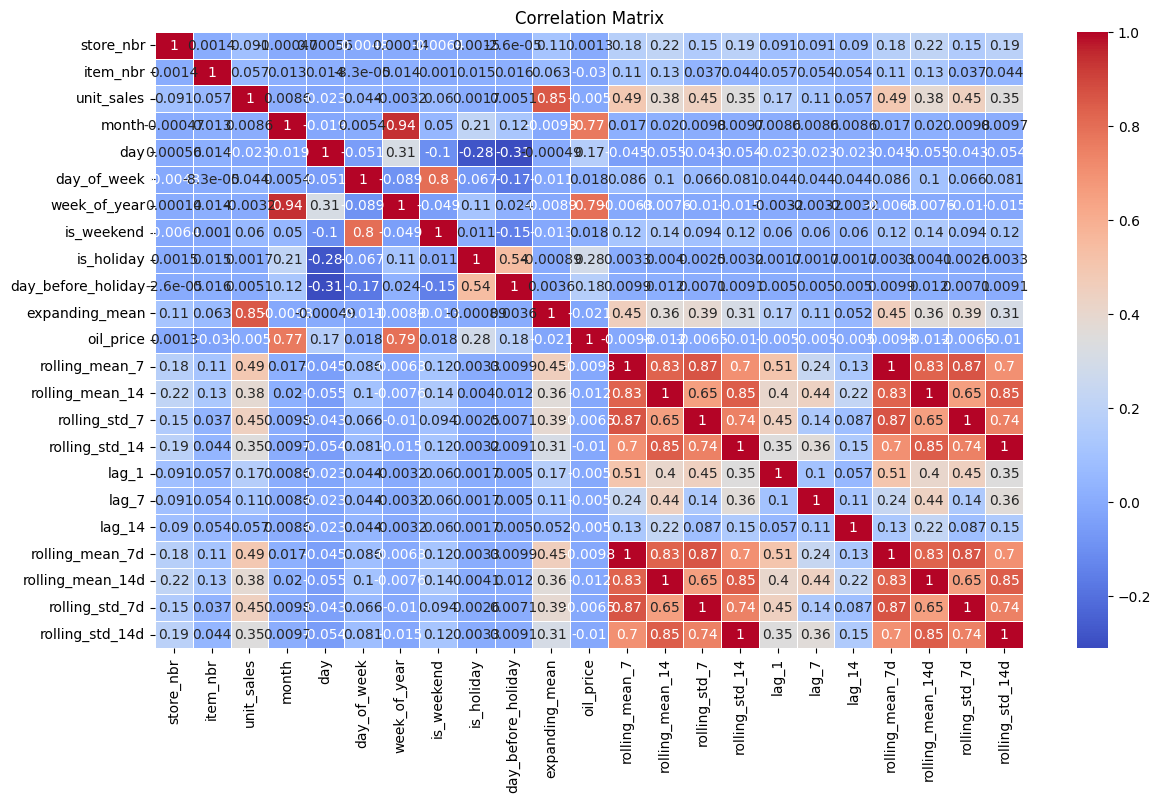

In [63]:
# Remove non-numeric
final_train = df_train.select_dtypes(exclude=['object'])
remove_corr = ['id', 'date', 'onpromotion','year']
final_train_corr = final_train.drop(remove_corr, axis=1)
# Corr Matrix
corr_matrix = final_train_corr.corr()
plt.figure(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

##Final Training Dataframe:

In [64]:
# Join Stores and Items to Final DF
final_train = final_train.merge(df_stores, on='store_nbr', how='left')
final_train = final_train.merge(df_items, on='item_nbr', how='left')

In [65]:
# Drop City and State
final_train = final_train.drop(['city', 'state'], axis=1)

In [66]:
# Hot encoding features
final_train = pd.get_dummies(final_train, columns=['family', 'type', 'cluster'], drop_first=True)

In [67]:
# Sort by ['store_nbr', 'item_nbr', 'date']
final_train = final_train.sort_values(['store_nbr', 'item_nbr', 'date'])

In [68]:
# Final df
final_train.tail()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,family_CLEANING,family_GROCERY I,type_B,type_C,type_D,type_E,cluster_3,cluster_6,cluster_10,cluster_17
597897,21391405,2014-03-27,51,1466049,2.0,0,2014,3,27,3,...,False,False,False,False,False,False,False,False,False,True
605020,21454795,2014-03-28,51,1466049,3.0,0,2014,3,28,4,...,False,False,False,False,False,False,False,False,False,True
612905,21523583,2014-03-29,51,1466049,2.0,0,2014,3,29,5,...,False,False,False,False,False,False,False,False,False,True
620785,21591094,2014-03-30,51,1466049,5.0,0,2014,3,30,6,...,False,False,False,False,False,False,False,False,False,True
628378,21656543,2014-03-31,51,1466049,3.0,0,2014,3,31,0,...,False,False,False,False,False,False,False,False,False,True


In [69]:
final_train.shape

(628379, 39)

In [70]:
final_train.describe()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,rolling_std_14,lag_1,lag_7,lag_14,rolling_mean_7d,rolling_mean_14d,rolling_std_7d,rolling_std_14d,class,perishable
count,6.283790e+05,628379,628379.000000,6.283790e+05,628379.000000,628379.0,628379.0,628379.000000,628379.000000,628379.000000,...,628379.000000,628379.000000,628379.000000,628379.000000,628373.000000,628366.000000,628373.000000,628366.000000,628379.000000,628379.0
mean,1.900205e+07,2014-02-15 02:09:18.797795584,32.632072,7.648717e+05,7.277586,0.0,2014.0,2.018234,15.627459,3.098511,...,8.863996,7.277584,7.277581,7.277517,7.277617,7.277635,7.830419,8.864076,1510.030198,0.0
min,1.632368e+07,2014-01-01 00:00:00,24.000000,9.699500e+04,0.000000,0.0,2014.0,1.000000,1.000000,0.000000,...,0.267599,0.000000,0.000000,0.000000,0.997857,1.070357,0.000000,0.267599,1002.000000,0.0
25%,1.771494e+07,2014-01-23 00:00:00,27.000000,3.783300e+05,2.000000,0.0,2014.0,1.000000,8.000000,1.000000,...,3.679465,2.000000,2.000000,2.000000,3.571429,4.071429,2.690371,3.679465,1036.000000,0.0
50%,1.899540e+07,2014-02-15 00:00:00,30.000000,8.127260e+05,3.000000,0.0,2014.0,2.000000,16.000000,3.000000,...,6.148349,3.000000,3.000000,3.000000,5.428571,5.857143,4.859943,6.148349,1078.000000,0.0
75%,2.028460e+07,2014-03-10 00:00:00,35.000000,1.091365e+06,7.000000,0.0,2014.0,3.000000,23.000000,5.000000,...,10.615405,7.000000,7.000000,7.000000,8.571429,8.714286,9.107820,10.615405,1148.000000,0.0
max,2.165654e+07,2014-03-31 00:00:00,51.000000,1.466049e+06,844.000000,0.0,2014.0,3.000000,31.000000,6.000000,...,223.704426,844.000000,844.000000,844.000000,140.000000,129.071429,316.877925,223.704426,3090.000000,0.0
std,1.519745e+06,NaN,7.980001,4.026918e+05,13.444829,0.0,0.0,0.846589,8.698178,2.027146,...,9.033616,13.444829,13.444835,13.444817,6.842183,5.659342,9.744675,9.033692,820.056788,0.0
